In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
# from spec_id import Oldest_galaxy,Likelihood_contours, Scale_model,Calzetti
from C_fit_full import Gen_spec
from C_MC_fit import Gen_sim
from scipy.interpolate import interp1d,interp2d
from grizli.multifit import GroupFLT, MultiBeam, get_redshift_fit_defaults
import grizli.model
from astropy.io import fits
from astropy import wcs
import pandas as pd
from glob import glob
from astropy.cosmology import Planck13, z_at_value
from matplotlib.gridspec import GridSpec
from astropy.io import fits
from astropy.table import Table
import os
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

In [2]:
galDB = pd.read_pickle('../data/upd_galDB.pkl')
metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [114]:
goods_s=Table.read(hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',format='ascii').to_pandas()
goods_n=Table.read(hpath + 'Clear_data/goodsn_mosaic/goodsn_3dhstP.cat',format='ascii').to_pandas()

if hpath == '/Users/Vince.ec/':
    catpath = hpath
else:
    catpath='/Users/vestrada/Desktop/'

restc_s=Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/RF_colors/goodss_3dhst.v4.1.master.RF',format='ascii').to_pandas()
restc_n=Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/RF_colors/goodsn_3dhst.v4.1.master.RF',format='ascii').to_pandas()

fast_s=Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout',format='ascii').to_pandas()
fast_n=Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout',format='ascii').to_pandas()

eazy_s = Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Eazy/goodss_3dhst.v4.1.zout',
               format = 'ascii').to_pandas()
eazy_n = Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Eazy/goodsn_3dhst.v4.1.zout',
               format = 'ascii').to_pandas()


In [115]:
IDS=[]
IDN=[]

for i in range(len(restc_s['id'])):
    if eazy_s.z_spec[i] != -1:
        rshift = eazy_s.z_spec[i]
    else: 
        rshift = eazy_s.z_peak[i]

    if 1.8<= rshift <= 3.18 and goods_s['class_star'][i]<0.8 and fast_s['lmass'][i] >= 9.95:
        IDS.append(i)

for i in range(len(restc_n['id'])):
    if eazy_n.z_spec[i] != -1:
        rshift = eazy_n.z_spec[i]
    else: 
        rshift = eazy_n.z_peak[i]

    if 1.8<= rshift <= 3.18 and goods_n['class_star'][i]<0.8 and fast_n['lmass'][i] >= 9.95:
        IDN.append(i)

In [116]:
def Mag(band):
    magnitude=25-2.5*np.log10(band)
    return magnitude

uvS=Mag(restc_s['L153'][IDS].values) - Mag(restc_s['L155'][IDS].values)
vjS=Mag(restc_s['L155'][IDS].values) - Mag(restc_s['L161'][IDS].values)
uvN=Mag(restc_n['L153'][IDN].values) - Mag(restc_n['L155'][IDN].values)
vjN=Mag(restc_n['L155'][IDN].values) - Mag(restc_n['L161'][IDN].values)
dustS = fast_s['Av'][IDS].values
dustN = fast_n['Av'][IDN].values

IDSQ=[]
IDSsf=[]

IDNQ=[]
IDNsf=[]


for i in range(len(uvS)):
    if uvS[i]>=0.88*vjS[i]+0.59 and uvS[i]>1.382 and vjS[i]<1.65:
        IDSQ.append(i)
    if uvS[i]<0.88*vjS[i]+0.59:
        IDSsf.append(i)
        
for i in range(len(uvN)):
    if uvN[i]>=0.88*vjN[i]+0.59 and uvN[i]>1.382 and vjN[i]<1.65:
        IDNQ.append(i)
    if uvN[i]<0.88*vjN[i]+0.59:
        IDNsf.append(i)

No handles with labels found to put in legend.


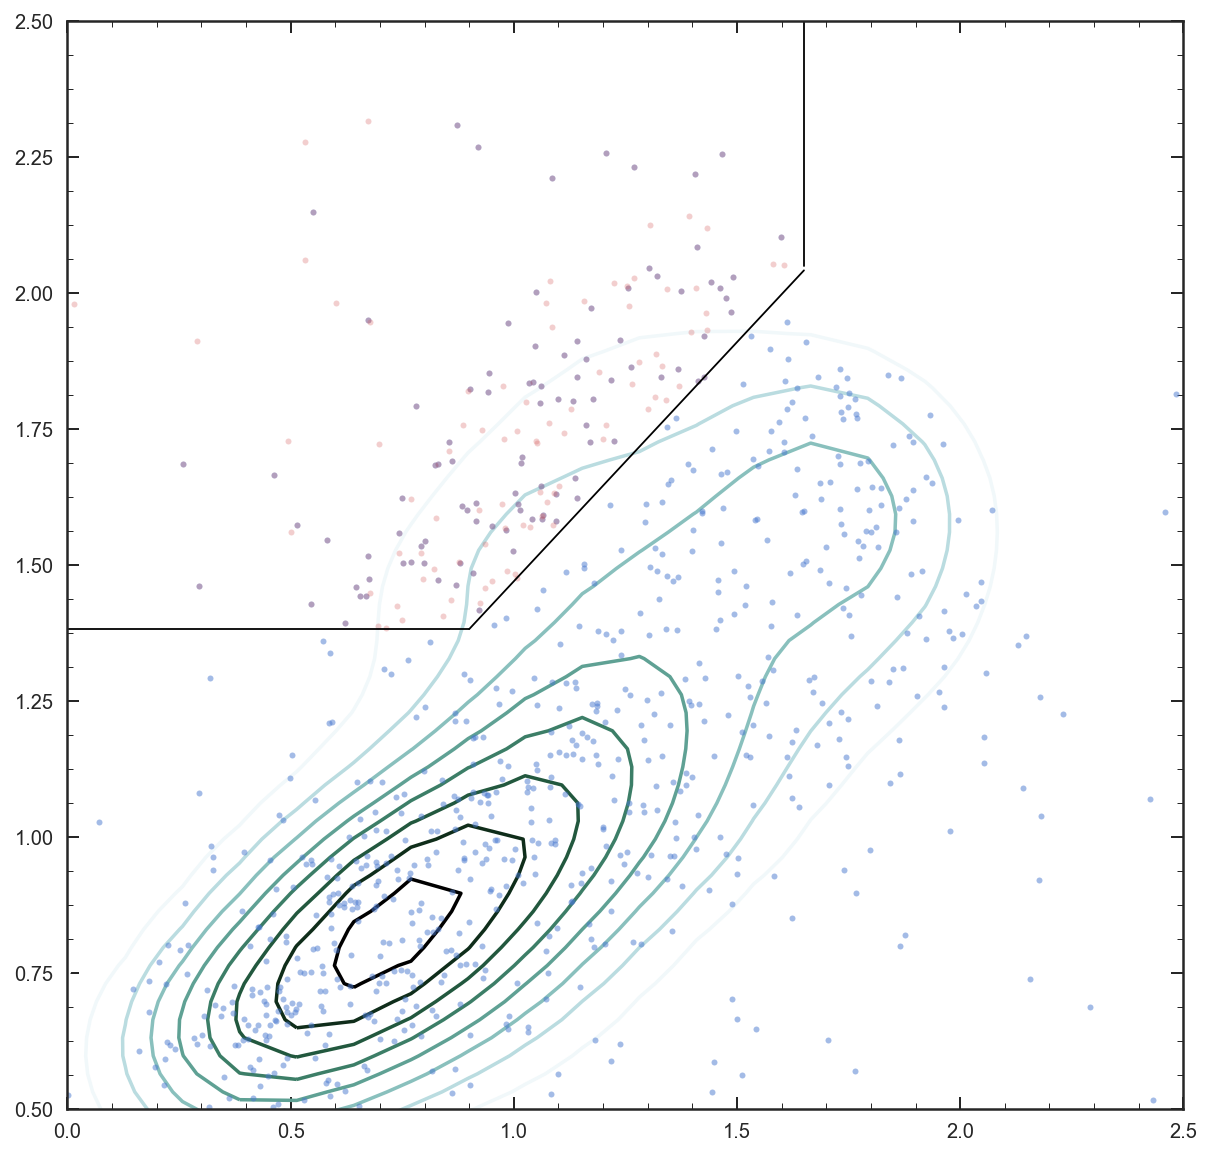

In [117]:
plt.figure(figsize=[10,10])
sea.kdeplot(np.append(vjS,vjN),np.append(uvS,uvN),cmap = cmap)
plt.plot(vjN,uvN,'o',color=sea.color_palette('muted')[0], alpha=.5,ms=3)
plt.plot(vjS[IDSQ],uvS[IDSQ],'o',color=sea.color_palette('muted')[2], alpha=.3,ms=3)
plt.plot(vjN[IDNQ],uvN[IDNQ],'o',color=sea.color_palette('muted')[2], alpha=.3,ms=3)
plt.plot([0,.9],[1.382,1.382],'k',lw=.9)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=.9)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9)
plt.axis([0,2.5,.5,2.5])
plt.legend(loc=2)

In [136]:
def Source_present(fns,DB):  ### finds source in flt file, returns if present and the pos in pixels
    
    inout = np.repeat('out',len(DB))
    loc = np.repeat('ooo',len(DB))
    
    for i in range(len(fns)):
        flt=fits.open(fns[i])
        field = flt[0].header['TARGNAME']
        if 'D' not in field:
            w = wcs.WCS(flt[1].header)
            xpixlim=len(flt[1].data[0])
            ypixlim=len(flt[1].data)

            for ii in range(len(DB.index)):

                [pos]=w.wcs_world2pix([[DB.ra[DB.index[ii]],DB.dec[DB.index[ii]]]],1)

                if -100 <pos[0]< xpixlim + 100  and -100 < pos[1] < ypixlim + 100:
                    inout[ii] = 'in'
                    loc[ii] = field
    return inout,loc

In [118]:
s_cand =pd.DataFrame({ 'gids' : eazy_s.id[np.array(IDS)],
    'zspec' : eazy_s.z_spec[np.array(IDS)],
    'zphot' : eazy_s.z_peak[np.array(IDS)],
    'ra' : goods_s.ra[np.array(IDS)],
    'dec' : goods_s.dec[np.array(IDS)],
    'in_out' : np.repeat('out',len(IDS))})

n_cand =pd.DataFrame({ 'gids' : eazy_n.id[np.array(IDN)],
    'zspec' : eazy_n.z_spec[np.array(IDN)],
    'zphot' : eazy_n.z_peak[np.array(IDN)],
    'ra' : goods_n.ra[np.array(IDN)],
    'dec' : goods_n.dec[np.array(IDN)],
    'in_out' : np.repeat('out',len(IDN))})

In [123]:
def Mag(band):
    magnitude=25-2.5*np.log10(band)
    return magnitude

S_SF = np.repeat('sf',len(s_cand))
N_SF = np.repeat('sf',len(n_cand))

for i in range(len(s_cand.index)):
    uv = Mag(restc_s['L153'][s_cand.gids[s_cand.index[i]] - 1]) - Mag(restc_s['L155'][s_cand.gids[s_cand.index[i]] - 1])
    vj = Mag(restc_s['L155'][s_cand.gids[s_cand.index[i]] - 1]) - Mag(restc_s['L161'][s_cand.gids[s_cand.index[i]] - 1])
    if uv>=0.88*vj+0.59 and uv>1.382 and vj<1.65:
        S_SF[i] = 'q'
    if uv<0.88*vj+0.59:
        S_SF[i] = 'sf'
    
for i in range(len(n_cand.index)):
    uv = Mag(restc_n['L153'][n_cand.gids[n_cand.index[i]] - 1]) - Mag(restc_n['L155'][n_cand.gids[n_cand.index[i]] - 1])
    vj = Mag(restc_n['L155'][n_cand.gids[n_cand.index[i]] - 1]) - Mag(restc_n['L161'][n_cand.gids[n_cand.index[i]] - 1])
    if uv>=0.88*vj+0.59 and uv>1.382 and vj<1.65:
        N_SF[i] = 'q'
    if uv<0.88*vj+0.59:
        N_SF[i] = 'sf'

In [125]:
s_cand['SF'] = S_SF
n_cand['SF'] = N_SF

In [137]:
filelist = glob(hpath + 'Clear_data/s_flt_files/*flt.fits')
s_pres,s_pos=Source_present(filelist,s_cand)

filelist = glob(hpath + 'Clear_data/n_flt_files/*flt.fits')
n_pres,n_pos=Source_present(filelist,n_cand)


In [139]:
s_cand['in_out'] = s_pres
n_cand['in_out'] = n_pres

s_cand['field'] = s_pos
n_cand['field'] = n_pos

In [144]:
s_cand

,dec,gids,in_out,ra,zphot,zspec,SF,field
19347,-27.821115,19348,in,53.148822,2.5737,2.582,sf,GS4
19866,-27.819231,19867,in,53.149052,2.4352,-1.000,sf,GS4
20265,-27.816314,20266,in,53.138382,2.5477,-1.000,sf,GS4
20297,-27.816563,20298,in,53.141624,2.6206,-1.000,sf,GS4
20402,-27.814930,20403,in,53.131381,1.9577,-1.000,q,GS4
20787,-27.814061,20788,in,53.165278,3.0855,3.064,sf,GS4
21388,-27.811080,21389,in,53.161418,2.8561,-1.000,sf,GS4
21816,-27.809059,21817,in,53.132370,3.1515,-1.000,sf,GS4
22026,-27.808235,22027,in,53.173658,1.9780,-1.000,sf,GS4
22153,-27.806919,22154,in,53.173967,2.1020,-1.000,sf,GS4


In [142]:
s_cand = s_cand.query('in_out == "in"')
n_cand = n_cand.query('in_out == "in"')

In [68]:
s_cand['field'] = np.repeat('ooo',len(s_cand))
n_cand['field'] = np.repeat('ooo',len(n_cand))

In [69]:
def Source_present(fn,ra,dec):  ### finds source in flt file, returns if present and the pos in pixels
    flt=fits.open(fn)
    present = False
    field = ''
    w = wcs.WCS(flt[1].header)

    xpixlim=len(flt[1].data[0])
    ypixlim=len(flt[1].data)

    [pos]=w.wcs_world2pix([[ra,dec]],1)

    if -100 <pos[0]< xpixlim + 100  and -100 < pos[1] < ypixlim + 100 and flt[0].header['OBSTYPE'] == 'SPECTROSCOPIC':
        present=True
        field = flt[0].header['TARGNAME']  
    return present,pos,field


In [70]:
filelist = glob(hpath + 'Clear_data/s_flt_files/*flt.fits')
for i in s_cand.index:
    for ii in range(len(filelist)):
        pres,pos,fie=Source_present(filelist[ii],s_cand.ra[i],s_cand.dec[i])
        if pres == True:
            s_cand.field[i]= fie
            print(pos)
            break
            
filelist = glob(hpath + 'Clear_data/n_flt_files/*flt.fits')
for i in n_cand.index:
    for ii in range(len(filelist)):
        pres,pos,fie=Source_present(filelist[ii],n_cand.ra[i],n_cand.dec[i])
        if pres == True:
            n_cand.field[i]= fie
            print(pos)
            break

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[-88.57018249 -27.03517097]
[-42.66609525 -20.37680312]
[245.67794    155.48179562]
[601.65420849 709.86410795]
[433.95571745 185.7492945 ]
[643.25057823 -52.42956902]
[1109.29799017  775.36338155]
[659.92879884 519.12634346]
[1056.80900719  710.59780421]
[374.44697113 562.35754944]
[ 92.49027062 614.67394542]
[179.7865019  798.22339381]
[  9.76047532 905.98710231]
[ 52.39650657 100.75454637]
[546.54486223 325.14199186]
[871.66015912 643.59547643]
[539.26056827 310.05770655]
[658.17959639 199.00341153]
[562.7444614  498.01265576]
[324.90220961 248.64154196]
[660.79135328  94.20699934]
[371.59553289 152.61846634]
[  13.85761422 1025.6929358 ]


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


[ 6.23684819 80.28677687]
[-98.63083743 674.65397475]
[-85.89690712 308.67394888]
[213.75930963 319.06487029]
[ 11.26689371 753.66695359]
[139.68344929 440.63527687]
[ 103.83370828 1011.85137665]
[ 94.79053575 862.87016438]
[ -90.83771624 1009.50914542]
[ -9.66917243 -50.46734235]
[388.20965738 718.00679952]
[669.3392587  755.27679744]
[320.70963369 171.22092694]
[340.86923811 421.94514358]
[629.16335991 268.66277237]
[39.48289137 -3.5925711 ]
[344.17248759 516.9862465 ]
[512.95984083 666.7940765 ]
[286.68035228 211.2018081 ]
[-70.37857847 514.26316202]
[ 256.22092577 1051.58753824]
[356.51657075 303.40711493]
[-89.85689034 759.95880568]
[  5.61076875 946.79728256]
[629.92087047 405.81207931]
[385.80481022 580.64555243]
[933.75031233  55.51415124]
[470.43550897 678.02594504]
[ -49.88311802 1098.42244839]
[815.78055645  86.74850906]
[458.62178467 504.94187127]
[1066.67662101  806.67849329]
[204.44653419 501.17993346]
[1048.06140592  -14.91348285]
[1056.03688388   70.37978441]
[478.76392

In [175]:
s_cand.query("field == 'ERS' and SF == 'sf'")

,dec,gids,in_out,ra,zphot,zspec,SF,field
36704,-27.737862,36705,in,53.042456,2.3124,2.3036,sf,ERS
37987,-27.734035,37988,in,53.051881,2.2519,-1.0000,sf,ERS
38009,-27.733385,38010,in,53.073496,2.6121,-1.0000,sf,ERS
38559,-27.731020,38560,in,53.078023,2.5703,-1.0000,sf,ERS
38778,-27.729143,38779,in,53.067701,2.5377,-1.0000,sf,ERS
39021,-27.728726,39022,in,53.067820,3.0171,-1.0000,sf,ERS
39089,-27.728200,39090,in,53.081427,1.9736,-1.0000,sf,ERS
39133,-27.728019,39134,in,53.068322,2.5298,-1.0000,sf,ERS
39567,-27.726325,39568,in,53.058858,2.1861,-1.0000,sf,ERS
40476,-27.721649,40477,in,53.054250,2.0419,-1.0000,sf,ERS


      Q  SF
GS1 = 2 11
GS2 = 4 23
GS3 = 4 27
GS4 = 6 39
GS5 = 2 27
ERS = 5 60
GN1 = 5 25
GN2 = 6 29
GN3 = 6 25
GN4 = 4 31
GN5 = 3 29
GN7 = 2 21

In [79]:
Planck13.angular_diameter_distance_z1z2(1.8,3.15)

<Quantity 397.58413359 Mpc>

In [80]:
Planck13.angular_diameter_distance_z1z2(1.,1.6)

<Quantity 487.19690488 Mpc>

In [108]:
31 / 7113309.2

4.358027906336477e-06

In [107]:
(Planck13.comoving_volume(1.8) - Planck13.comoving_volume(1.0)) * np.radians((rad)**2) / (4*np.pi) * 12

<Quantity 7113309.18789835 Mpc3>

In [109]:
(Planck13.comoving_volume(3.15) - Planck13.comoving_volume(1.8)) * np.radians((rad)**2) / (4*np.pi) * 12

<Quantity 13990928.99627661 Mpc3>

In [105]:
Planck13.arcsec_per_kpc_comoving(1)

<Quantity 0.06075263 arcsec / kpc>

In [87]:
dat = fits.open('/Users/Vince.ec/Clear_data/s_flt_files/icxt01cgq_flt.fits')

In [91]:
w = wcs.WCS(dat[1].header)

pos=w.wcs_pix2world([[0,0],[0,1024]],1)

In [94]:
pos1

array([ 53.14028024, -27.6681124 ])

In [93]:
pos1,pos2 = pos

In [95]:
cosr = np.sin(np.radians(pos1[1])) * np.sin(np.radians(pos2[1])) + np.cos(np.radians(pos1[1]))\
                * np.cos(np.radians(pos2[1])) * np.cos(np.radians(pos1[0]) - np.radians(pos2[0]))
rad = np.arccos(cosr)
rad = np.degrees(rad)

In [7]:
def Sig_int(er):
    sig = np.zeros(len(er)-1)
    
    for i in range(len(er)-1):
        sig[i] = np.sqrt(er[i]**2 + er[i+1]**2 )
    
    return np.sum((1/2)*sig)

def SNR(wv,fl,er):
    IDX = [U for U in range(len(wv)) if 8500 < wv[U] < 10500]
    return np.trapz(fl[IDX])/ Sig_int(er[IDX])

def SNR_4000(rf_wv,fl,er):
    IDX = [U for U in range(len(rf_wv)) if 4000 < rf_wv[U] < 4100]
    return np.trapz(fl[IDX])/ Sig_int(er[IDX])


def SNR_correct(wave,flux,error,SNR_desired): 
    sno = SNR(wave,flux,error)
    return sno / SNR_desired

In [9]:
ID = ['s39631' ,'n21566','s40223','s40862']

sp1 = Gen_sim('s40223', 0.019,3.2,0,1.1,0,20)
sp2 = Gen_sim('s40223', 0.019,3.2,0,1.25,0,20)
sp3 = Gen_sim('s40223', 0.019,3.2,0,1.35,0,20)
sp4 = Gen_sim('s40223', 0.019,3.2,0,1.6,0,20)


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt

In [10]:
print(SNR(sp1.gal_wv,sp1.flx_err,sp1.gal_er))
print(SNR(sp2.gal_wv,sp2.flx_err,sp2.gal_er))
print(SNR(sp3.gal_wv,sp3.flx_err,sp3.gal_er))
print(SNR(sp4.gal_wv,sp4.flx_err,sp4.gal_er))

19.98481723894599
20.18106659998171
19.6255215427679
19.837555605409527


In [11]:
print(SNR_4000(sp1.gal_wv_rf,sp1.flx_err,sp1.gal_er))
print(SNR_4000(sp2.gal_wv_rf,sp2.flx_err,sp2.gal_er))
print(SNR_4000(sp3.gal_wv_rf,sp3.flx_err,sp3.gal_er))
print(SNR_4000(sp4.gal_wv_rf,sp4.flx_err,sp4.gal_er))

9.227507475699378
18.08914074501109
25.88542803749775
50.11278369900014


<ErrorbarContainer object of 3 artists>

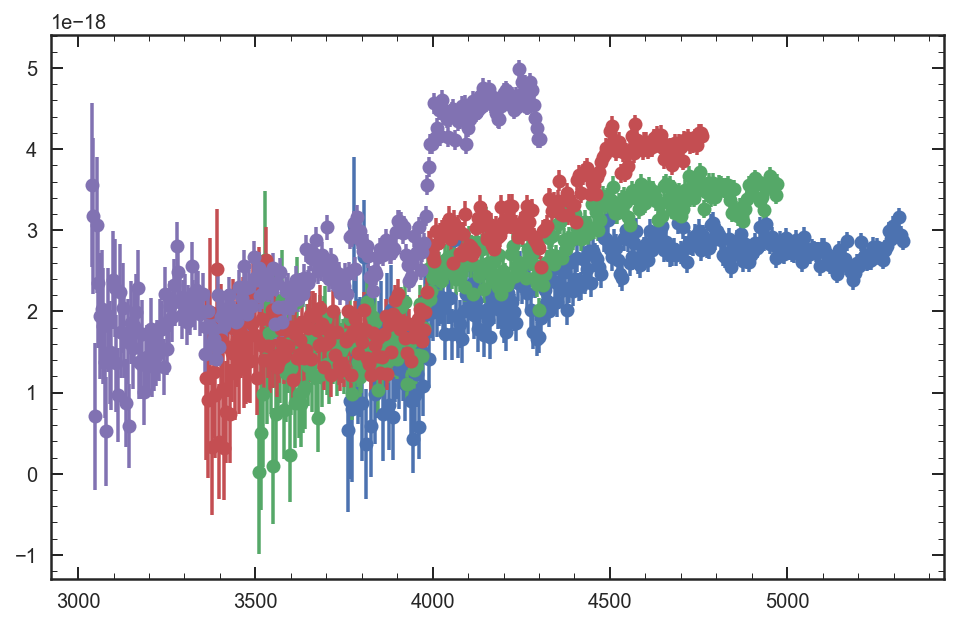

In [13]:
plt.figure(figsize=[8,5])
plt.errorbar(sp1.gal_wv_rf,sp1.flx_err,sp1.gal_er,fmt='o')
# plt.figure(figsize=[8,5])
plt.errorbar(sp2.gal_wv_rf,sp2.flx_err,sp2.gal_er,fmt='o')
# plt.figure(figsize=[8,5])
plt.errorbar(sp3.gal_wv_rf,sp3.flx_err,sp3.gal_er,fmt='o')
# plt.figure(figsize=[8,5])
plt.errorbar(sp4.gal_wv_rf,sp4.flx_err,sp4.gal_er,fmt='o')

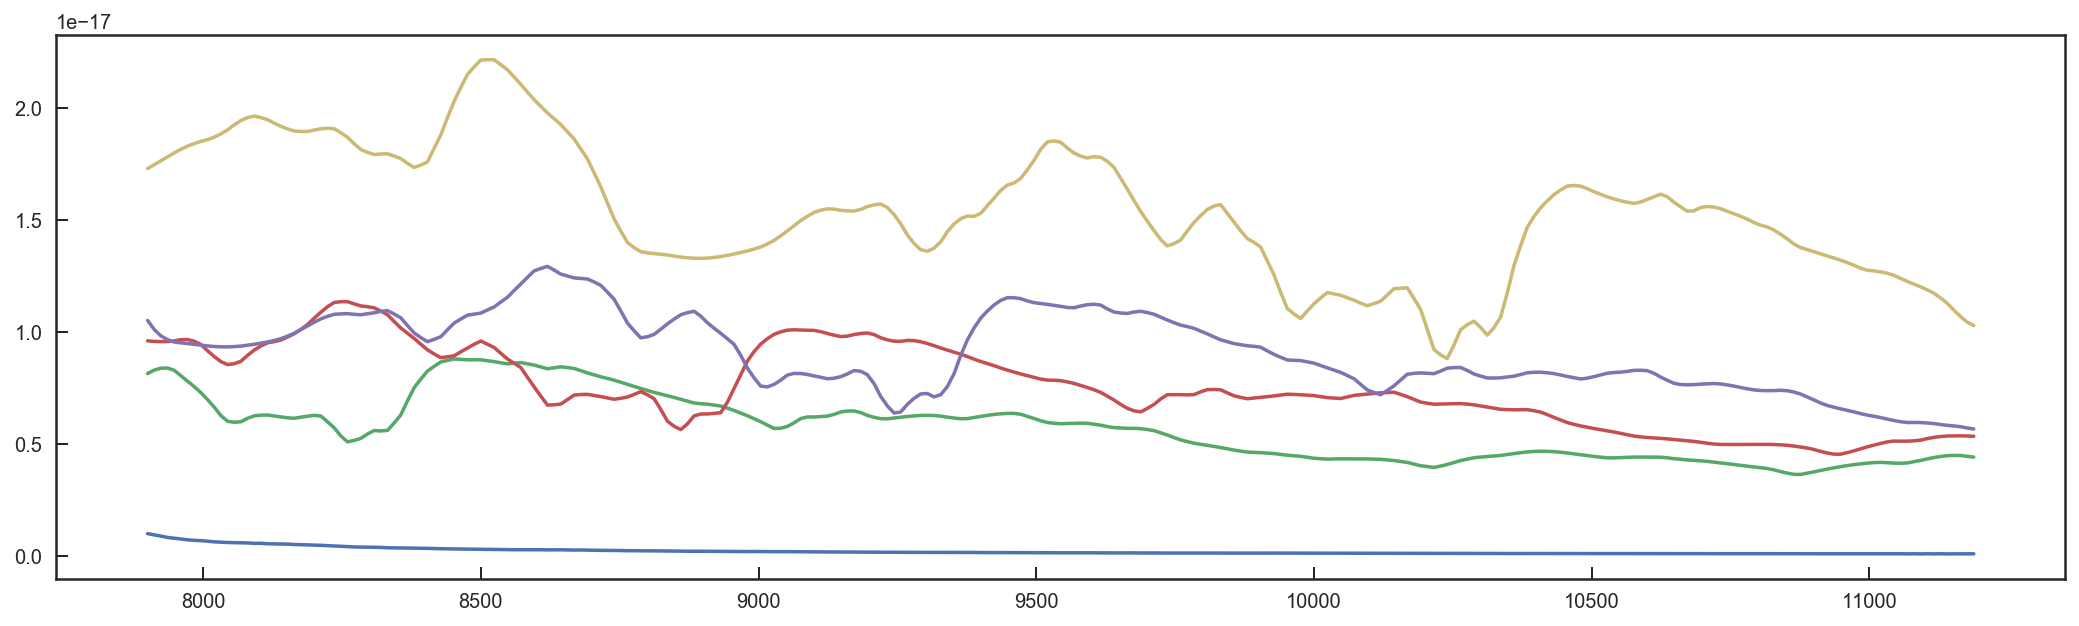

In [171]:
# plt.figure(figsize=[18,5])
# plt.plot(sp1.gal_wv,sp1.o_er)
# plt.plot(sp2.gal_wv,sp2.o_er)
# plt.plot(sp3.gal_wv,sp3.o_er)
# plt.plot(sp4.gal_wv,sp4.o_er)

plt.figure(figsize=[18,5])
plt.plot(sp4.gal_wv,sp4.o_er)
plt.plot(sp1.gal_wv,sp1.gal_er)
plt.plot(sp2.gal_wv,sp2.gal_er)
plt.plot(sp3.gal_wv,sp3.gal_er)
plt.plot(sp4.gal_wv,sp4.gal_er)

In [172]:
print(len(sp1.gal_wv))
print(len(sp2.gal_wv))
print(len(sp3.gal_wv))
print(len(sp4.gal_wv))

275
275
275
275


In [173]:
chi1=[]
chi2=[]
chi3=[]
chi4=[]

for i in range(age.size):
    sp1.Sim_spec(0.019,age[i],0)
    chi1.append(sum(((sp1.flx_err - sp1.fl) / sp1.gal_er)**2))

    sp2.Sim_spec(0.019,age[i],0)
    chi2.append(sum(((sp2.flx_err - sp2.fl) / sp2.gal_er)**2))
    
    sp3.Sim_spec(0.019,age[i],0)
    chi3.append(sum(((sp3.flx_err - sp3.fl) / sp3.gal_er)**2))
    
    sp4.Sim_spec(0.019,age[i],0)
    chi4.append(sum(((sp4.flx_err - sp4.fl) / sp4.gal_er)**2))

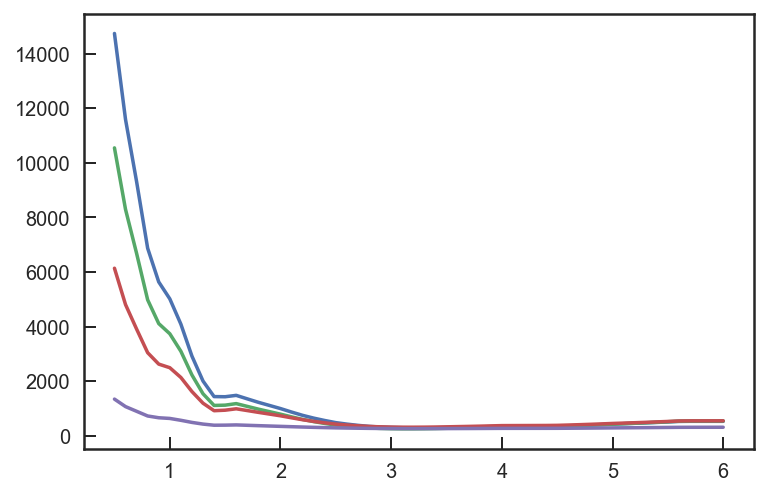

In [174]:
plt.plot(age,chi1)
plt.plot(age,chi2)
plt.plot(age,chi3)
plt.plot(age,chi4)

In [175]:
P1 = np.exp(-np.array(chi1)/2) / np.trapz(np.exp(-np.array(chi1)/2),age)
P2 = np.exp(-np.array(chi2)/2) / np.trapz(np.exp(-np.array(chi2)/2),age)
P3 = np.exp(-np.array(chi3)/2) / np.trapz(np.exp(-np.array(chi3)/2),age)
P4 = np.exp(-np.array(chi4)/2) / np.trapz(np.exp(-np.array(chi4)/2),age)

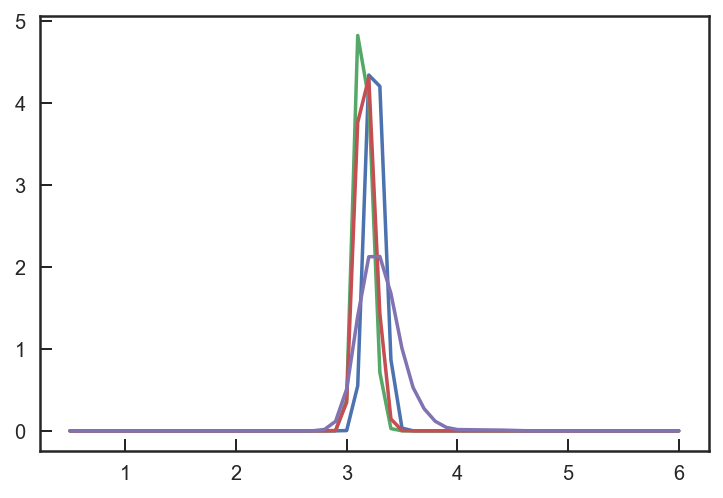

In [176]:
plt.plot(age,P1)
plt.plot(age,P2)
plt.plot(age,P3)
plt.plot(age,P4)

In [18]:
errgrid=[]
newwv = np.arange(7800,11300,1)
for i in galDB.index:
    try:
        wv,fl,er = np.load('../spec_stacks/{0}.npy'.format(galDB.gids[i]))
        errgrid.append(interp1d(wv,er)(newwv))
    except:
        print('skip')

In [22]:
med_err =np.zeros(len(np.array(errgrid).T))
for i in range(len(np.array(errgrid).T)):
    med_err[i] = np.median(np.array(errgrid).T[i])

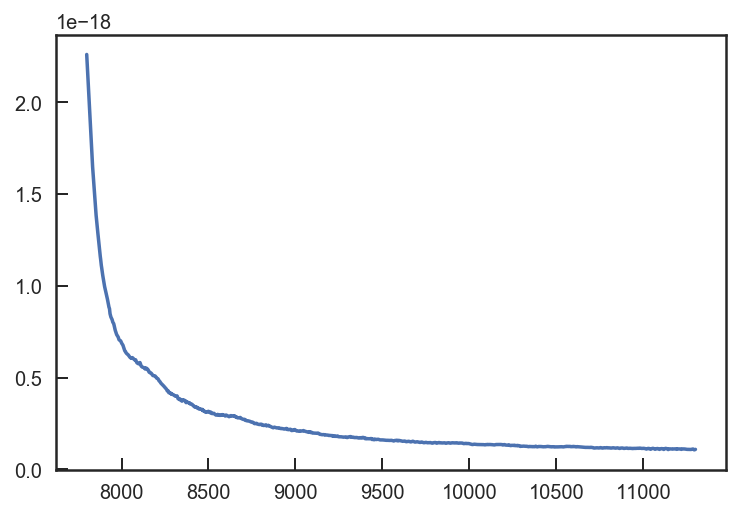

In [23]:
plt.plot(newwv,med_err)

In [24]:
np.save('../data/med_err',[newwv,med_err])

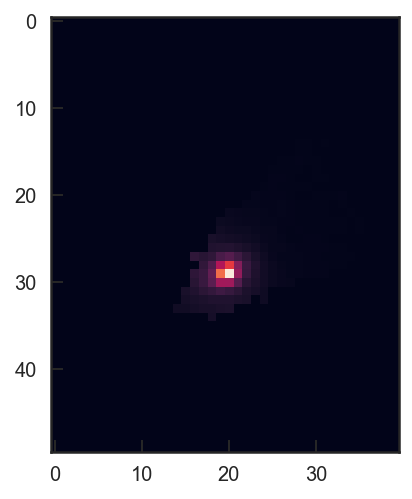

In [45]:
plt.imshow((sp1.beam.beam.direct*(sp1.beam.beam.seg == 39631))[50:100,60:100])

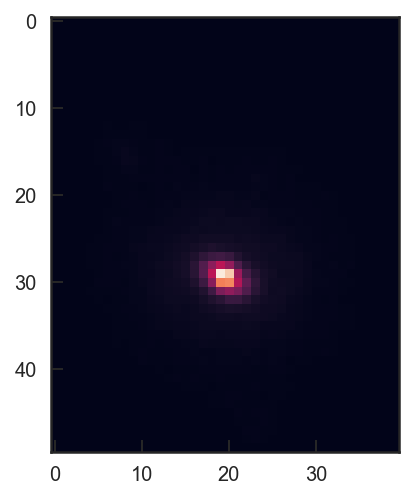

In [48]:
plt.imshow((sp2.beam.beam.direct*(sp2.beam.beam.seg == 21156))[50:100,60:100])

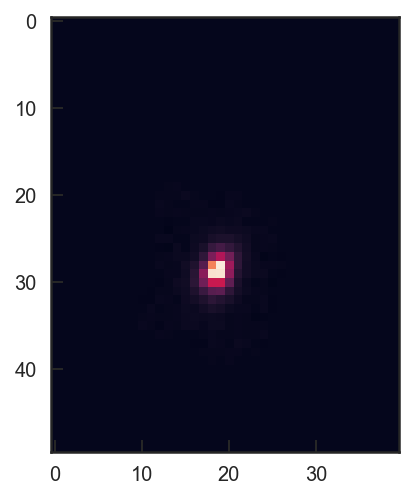

In [47]:
plt.imshow((sp3.beam.beam.direct*(sp3.beam.beam.seg == 40223))[50:100,60:100])

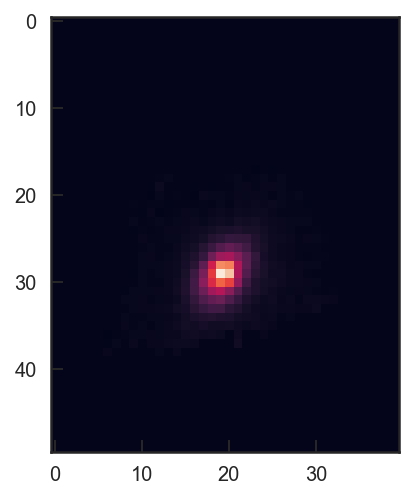

In [46]:
plt.imshow((sp4.beam.beam.direct*(sp4.beam.beam.seg == 40862))[50:100,60:100])